Systems
============

In this notebook we will examine the systems in underworld. This is a continuation of the user guides and so there is a certain amount of assumed knowledge regarding swarms, FE variables and functions.

We will start with the simplest system, the heat equation, in order to focus on how to setup the boundary conditions. Then the Stokes system is setup and solved, followed by particle advection and finally a mix of a Stokes and advecting system.

**This notebook is broken down into the following examples:**

1. Steady state heat equation with emphasis on boundary conditions
2. Stokes systems
3. Particle advection
4. Stokes system with particle advection

**Keywords:** underworld systems, boundary conditions, heat equation, Stokes system, advection system

**References**

1. T. J. R. Hughes. The Finite Element Method: Linear Static and Dynamic Finite Element Analysis. Prentice-Hall, Inc. 1987

In [1]:
import underworld as uw
from underworld import function as fn
import glucifer
import math
import numpy as np

Set simulation resolution and domain size for use in all examples below.

In [2]:
res = 64
boxLength = 1.0
boxHeight = 1.0

Steady state heat equation
-----

As an example of the simplest system in Underworld we will setup and solve the steady state heat equation given by
$$
    \nabla(k\nabla)T = h
$$
where $k$ is the conductivity, T is the temperature field (solved for) and $h$ is any additional heating term. Subject to known boundary conditions and initial conditions. 

This is the strong form of the heat equation, which is converted to the weak form and subsequently used in the finite element method utilised in the Underworld solvers. For information regarding the how the weak form is used to build the finite element method the reader is referred to Hughes (1987).

Here we will focus on setting up boundary conditions. With this in mind a simple mesh and temperature finite element variable is set up.

In [3]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight))
temperatureField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )

**Finding the boundary indices**

As discussed in user guide **TheMesh**, the mesh consists of a list of mesh nodes each with a distinct index and spatial coordinate. 

Here we will use a particle swarm to highlight the boundaries of the mesh.

In [4]:
# set a swarm where each particle sits on a mesh node
swarm = uw.swarm.Swarm( mesh=mesh )
swarmCoords = mesh.data
swarm.add_particles_with_coordinates(swarmCoords)
# add an index variable to the swarm
swarmIndex = swarm.add_variable( dataType="int", count=1 )

Lets look at the special index sets - these contain the vertex numbers for along each boundary. 

In [5]:
mesh.specialSets.keys()

['MaxI_VertexSet',
 'MinI_VertexSet',
 'AllWalls',
 'AllWalls_VertexSet',
 'MinJ_VertexSet',
 'MaxJ_VertexSet',
 'Empty']

By convention, where the mesh has a resolution (I, J), we consider that I is the resolution is in the x direction and J is the resolution in the y direction. The vertices across the bottom of the domain are therefore contained within minimum 'J' set, and those across the top are in maximum 'J' set. 

Next we will highlight the bottom boundary by setting the swarm index in the special set "MinJ_VertexSet" to one, while the rest are set to zero. This same code can be used to look at the other boundaries listed in the special sets key above.

In [6]:
swarmIndex.data[:] = 0
for index in mesh.specialSets["MinJ_VertexSet"]:
    swarmIndex.data[index]=1

Visualise the highlighted swarm particles on the bottom boundary.


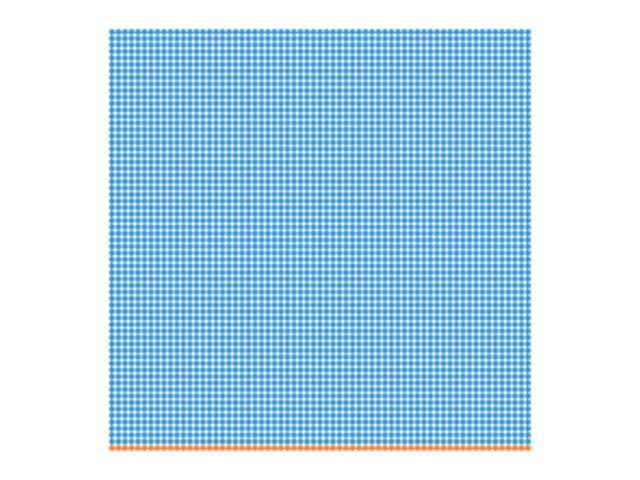

In [7]:
fig1 = glucifer.Figure()
fig1.append( glucifer.objects.Points(swarm=swarm, fn_colour=swarmIndex, pointSize=8, colourBar=False) )
fig1.show()

###Setting boundary conditions

Now that we know how to obtain the indices for the boundaries we can use this approach to set the values for temperature along the boundary.

Firstly, set initial data for temperature

In [8]:
temperatureField.data[:] = 0.

Now set the temperature values along the top and bottom boundaries using the special sets of indices.

In [9]:
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = 1.0
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = 0.0

Plot the temperature field


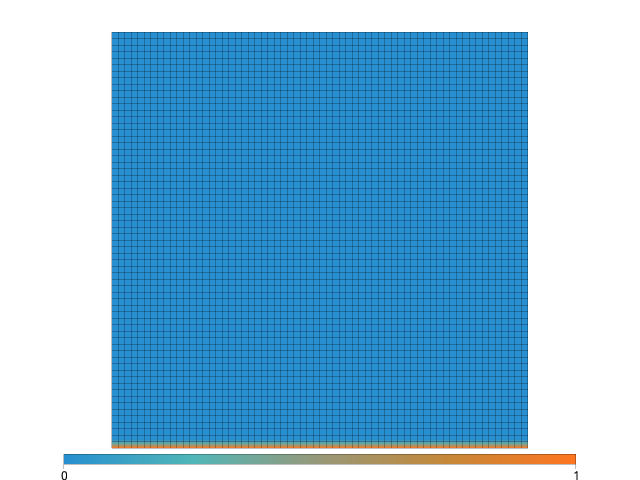

In [10]:
figtemp = glucifer.Figure()
figtemp.append( glucifer.objects.Surface( mesh, temperatureField) )
figtemp.append( glucifer.objects.Mesh(mesh) )
figtemp.show()

**Flag boundaries as Dirichlet**

Using the special sets, we construct a set of mesh indices for the bottom and top walls which we will use to construct conditions on the system.

In [11]:
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

Underworld needs to know which vertices you wish to have fixed values on, i.e. which vertices should be flagged as conditions on the system. We are effectively telling the solver that for flagged vertices, the values are already known and it should not modify them (although it will certainly read and use them).

We use the DirechletCondition object to achieve this. This object will be passed into the solver below. For more information of Direchlet conditions see [here](https://en.wikipedia.org/wiki/Dirichlet_boundary_condition).

In [12]:
tempBC = uw.conditions.DirichletCondition( variable      = temperatureField, 
                                           indexSetsPerDof = (jWalls,) )

###Setup a heat equation solver

Firstly the system of equations is setup. In this case the steady state heat equations. The inputs for this system of equations are the temperature field, the conductivity (a function or a single value as it is here) and the boundary conditions for the temperature field.

In [13]:
heatequation = uw.systems.SteadyStateHeat(temperatureField=temperatureField, conductivityFn=1.0, conditions=[tempBC,])

Next we create a solver for the system of equations. This makes it easier to keep track of solver options for more complex systems of equations.

In [14]:
heatsolver = uw.systems.Solver(heatequation)

Finally we solve the solver object which contains the system of equations. For time dependent systems this step will be inside a main time loop, along with any advection/diffusion solvers (see example below).

In [15]:
heatsolver.solve()

Note that the conditions field has the temperature boundary conditions (``tempBC``) passed into it as a single field in a python tuple. Since this system consists of a temperature field only there is only a single value at each mesh point. For the velocity field this is more complicated (**see velocity boundary condition example below**).

Below is the temperature field after solving the steady state heat equation.


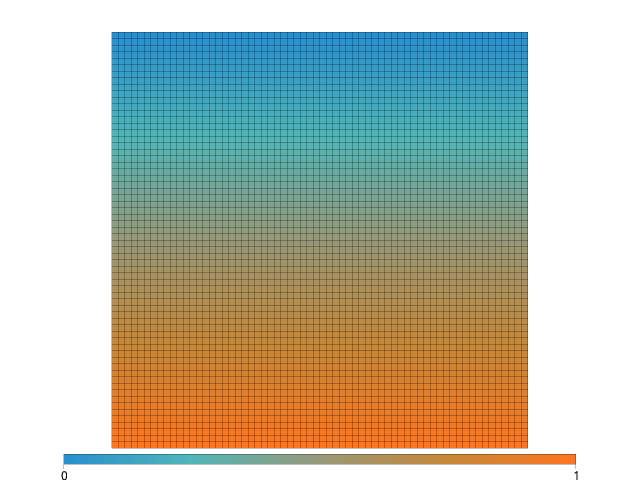

In [16]:
figtemp.show()

**Advanced "boundary" condition example**

Since the ``DirechletCondition`` is set by the index of the mesh we can play with this to hold any point of the temperature field constant - not just the boundary.

As an example let's set the wall boundaries to equal zero and fix the central temperature to be one.

In [17]:
# set T = 0 everywhere
temperatureField.data[:] = 0.
# get list of all vertices on the mesh boundary - these will be fixed as conditions below
allFixed = mesh.specialSets["AllWalls_VertexSet"]
# find the middle point in the mesh and set T=1 there
midindex = len(mesh.data)/2
temperatureField.data[midindex]=1.0
print('Mid index = {0:6d}; vertex position = ({1:.3f}, {2:.3f})'
      .format(midindex, mesh.data[midindex][0], mesh.data[midindex][1]))
# Add mesh point to index set "allFixed"
print('Number of vertices on boundary   = {0:6d}'.format(len(allFixed.data)))
allFixed.add(midindex)
print('Number of vertices to keep fixed = {0:6d}'.format(len(allFixed.data)))

Mid index =   2112; vertex position = (0.500, 0.500)
Number of vertices on boundary   =    256
Number of vertices to keep fixed =    257


Fix the temperatures on the special list of mesh vertices for all simulation time by flagging them as Dirichlet conditions. This list consists of all mesh points on the edge of the simulation box and a single mesh point in the centre of the box. 

In [18]:
tempBC = uw.conditions.DirichletCondition( variable      = temperatureField, 
                                           indexSetsPerDof = (allFixed) )

**Solve the heat equation**

Solve the heat equation for $T = 0$ on the boundary and $T = 1$ in the centre. 

In [19]:
heatequation = uw.systems.SteadyStateHeat(temperatureField=temperatureField, conductivityFn=1.0, conditions=[tempBC,])
heatsolver=uw.systems.Solver(heatequation)
heatsolver.solve()

Plot steady state solution for the temperature


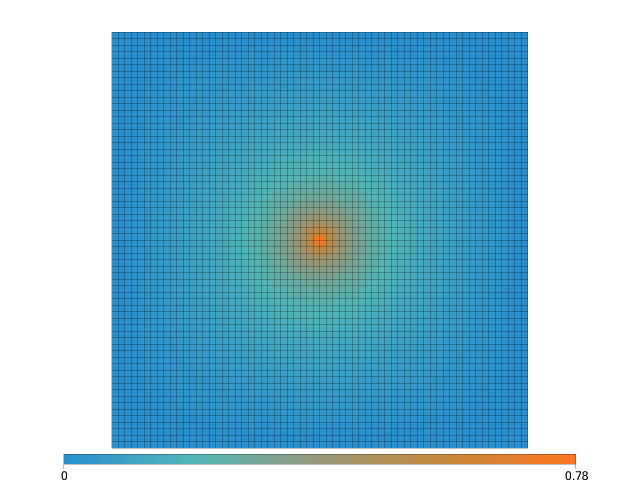

In [20]:
figtemp.show()

Stokes systems
-------

For most geodynamics problems the motion of the fluid is well described by the [Stokes equation](https://en.wikipedia.org/wiki/Stokes_flow) which is a a linearisation of the steady state Navier-Stokes Equations. Like the steady state heat equation, a Stokes system is solved at a given instant in time where the viscosity field and other forces are assumed constant. The strong form of the Stokes equation is given by
$$
    \eta \nabla^2 \mathbf{u} - \nabla p = g \rho \mathbf{\hat{z}}
$$
where $\eta$ is the viscosity, $\mathbf{u}$ is the velocity field, $p$ is the pressure field, $g$ is the local gravitational constant, $\rho$ is the density and $\mathbf{\hat{z}}$ is the vertical unit vector (directed opposite to gravity). Where the velocity field must also satisfy the incompressible fluid constraint, namely that $\nabla.\mathbf{u} = 0$ as well as any boundary conditions imposed on the velocity field. 

Solving the Stokes system is quite involved. Broadly speaking the strong form given above is converted into the weak form which forms the basis of the finite element method which requires solving matrices of the form $A \mathbf{x} = \mathbf{b}$ to determine the velocity field. The details of this approach are given in Hughes 1989 and the details of the solving methods used in Underworld are given in the user guide **09_StokesSolver**.

From a practical standpoint, setting up such a system requires pressure, viscosity and buoyancy forces ($g \rho \mathbf{\hat{z}}$) be passed to the Stokes system function. For such systems the temperature field affects the system via the density which is included in the buoyancy force. The Stokes system also requires knowledge of any conditions affecting these variables - in this case the boundary conditions for the velocity field. 


Firstly we setup the mesh and some FE variables.

In [21]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight))
velocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField    = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

Setup some quick initial conditions.

In [22]:
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.
for index, coord in enumerate(mesh.data):
    pertCoeff = math.cos( math.pi * coord[0]/boxLength ) * math.sin( math.pi * coord[1]/boxLength )
    temperatureField.data[index] = 1.0*(boxHeight - coord[1]) + 0.01 * pertCoeff
    temperatureField.data[index] = max(0.0, min(1.0, temperatureField.data[index]))

**Boundary conditions for velocity fields**

For two dimensional vector variables, we may flag up two Dirichlet conditions on each vertex.. for velocity it's a condition for $v_x$ and one for $v_y$. We provide a tuple of sets specifying which degrees of freedom (Set($v_x$), Set($v_y$)) should be considered Dirichlet. So the conditions below mean that the velocity components are fixed (at zero) in the horizontal direction for the side vertical walls, and fixed for the vertical components for the top and bottom walls. In other words no material can flow out of the simulation box.

As in the previous example, the temperature is held constant on the top and bottom boundaries via the tempBC object created below.

In [23]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

In [24]:
freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = (iWalls, jWalls) )
tempBC     = uw.conditions.DirichletCondition( variable      = temperatureField, 
                                               indexSetsPerDof = (jWalls,) )

**Set up material parameters and functions**

Here quick functions for viscosity, density and buoyancy force are set.

In [25]:
# Set viscosity to be a constant.
viscosity = 1.
# Rayleigh number.
Ra = 1.0e4
# Construct our density function.
densityFn = Ra * temperatureField
# Define our vertical unit vector using a python tuple (this will be automatically converted to a function).
z_hat = ( 0.0, 1.0 )
# Now create a buoyancy force vector using the density and the vertical unit vector. 
buoyancyFn = densityFn * z_hat

**Set up equations for the system to solve**

The Stokes system takes the pressure, viscosity and body forces (here the buoyancy) and solves for the velocity field.

In [26]:
stokesPIC = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               conditions    = [freeslipBC,],
                               viscosityFn   = viscosity, 
                               bodyForceFn   = buoyancyFn )

Create a solver for the system of equations. The system is then solved by using the ``.solve`` method on this object.

In [27]:
solver = uw.systems.Solver( stokesPIC )

In this case the system of equations has no velocity dependence, e.g. the density function does not depend on the velocity field as is the case with swarm particles (see below). As there is no dependence on velocity then we can solve for the velocity field in a linear way. Hence the solver does not need to iterate over the velocity field.

In [28]:
solver.solve( nonLinearIterate=False )

Plot the resulting temperature and velocity fields.


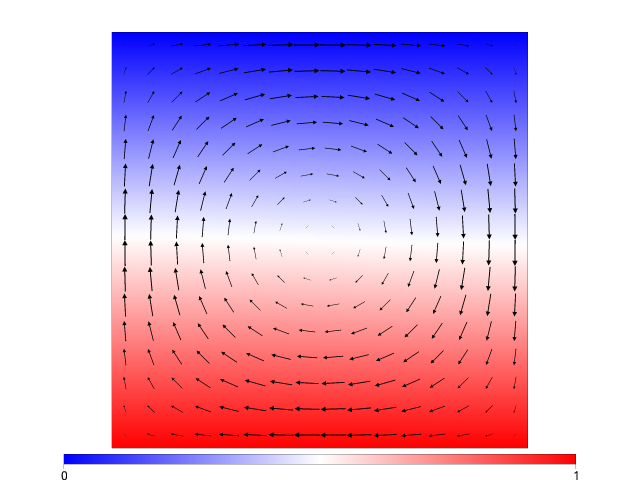

In [29]:
fig2 = glucifer.Figure()
velmagfield = uw.function.math.sqrt( uw.function.math.dot( velocityField, velocityField ) )
fig2.append( glucifer.objects.VectorArrows( mesh, velocityField/(4.0), arrowHead=0.2, scaling=0.1 ) )
fig2.append( glucifer.objects.Surface( mesh, temperatureField, colours="blue white red" ) )
fig2.show()

Particle advection
-----

The advection-diffusion equation for composition in the Lagrangian frame is 
$$
    \frac{ D \Gamma }{D t} = D \nabla^2 \Gamma
$$
where $\Gamma$ is composition, $D$ is diffusivity and $t$ is time. When there is no diffusion the right hand side is set to zero.


**Tracer particle moving through constant velocity field**

In this example we will use the previously calculated velocity field (stored in ``velocityField``) to advect a test particle around the simulation domain. Firstly, we create a particle swarm to add a single tracer particle to move in response to the velocity field.

In [30]:
# initialise a swarm. Note this must be the whole mesh, i.e. elementMesh.
swarm = uw.swarm.Swarm( mesh=mesh )
# Setup an array containing the position data for the tracer
particleCoordinates = np.zeros((1,2))     # 1 is for the number of particles,
                                          # 2 for the number of dimensions for the position.
# Copy position data for the sphere into the newly created array
particleCoordinates[0] = (0.5, 0.9)
# Use this array to add particles to the swarm.
swarm.add_particles_with_coordinates(particleCoordinates)
print('Initial particle coordinates = ({0:.2f}, {1:.2f})'
      .format(swarm.particleCoordinates.data[0][0],swarm.particleCoordinates.data[0][1]))

Initial particle coordinates = (0.50, 0.90)


Plot the initial particle position superimposed with the velocity field.


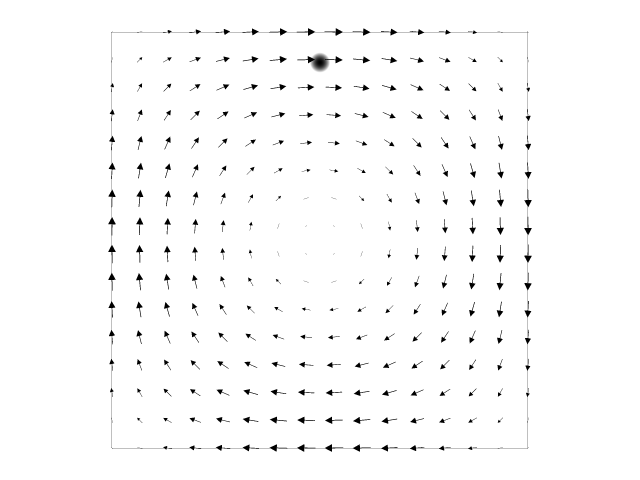

In [31]:
fig2 = glucifer.Figure()
fig2.append( glucifer.objects.VectorArrows( mesh, velocityField/(6.0), arrowHead=0.4, scaling=0.1 ) )
fig2.append( glucifer.objects.Points( swarm=swarm, pointSize=20, colourBar = False ) )
fig2.show()

**Setup an advection system**

The ``SwarmAdvector`` system takes the velocity field and advects the particles in the swarm in response to the velocity field.

In [32]:
advector  = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )

Step the tracer particle forward in time by integrating the advection system forward by a single time step. The maximum time step is determined using

$$
\Delta t = 0.5 \frac{\Delta x}{|\mathbf{u}|}
$$

in the case of independent Stokes flow and

$$
\Delta t = C \frac{ (\Delta x)^2 }{K}
$$

when the advection system also includes diffusion. Where $\Delta x$ is the minimum element width, $|\mathbf{u}|$ is the maximum velocity magnitude over the simulation domain, $C$ is the [Courant number](https://en.wikipedia.org/wiki/Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition), and $K$ is the maximum value of thermal diffusivity.

The maxmimum timestep for this system is found by the following.

In [33]:
print('Maximum timestep = {0:.3e}'.format(advector.get_max_dt()))

Maximum timestep = 3.085e-03


The system is repeatedly integrated forward in time using the largest possible timestep in the following loop.

In [34]:
time = 0.
step = 0
steps_end = 10
while step < steps_end:
    # Retrieve the maximum possible timestep for the AD system.
    dt = advector.get_max_dt()
    if step == 0: # first step is initial positions (t=0)
        dt = 0.
    # Advect using this timestep size   
    advector.integrate(dt)
    step += 1
    time += dt
    print('t = {0:.3f}; x = {1:.3f}, y = {2:.3f}'
          .format(time,swarm.particleCoordinates.data[0][0],swarm.particleCoordinates.data[0][1]))


t = 0.000; x = 0.500, y = 0.900
t = 0.003; x = 0.507, y = 0.900
t = 0.006; x = 0.515, y = 0.900
t = 0.009; x = 0.522, y = 0.900
t = 0.012; x = 0.530, y = 0.900
t = 0.015; x = 0.537, y = 0.899
t = 0.019; x = 0.544, y = 0.899
t = 0.022; x = 0.552, y = 0.899
t = 0.025; x = 0.559, y = 0.898
t = 0.028; x = 0.566, y = 0.898


Plot final position of particle with the (constant) velocity field. As expected it has moved slightly in the direction of the velocity field at it's initial position. If the main loop is continued the particle will circulate around the simulation box.


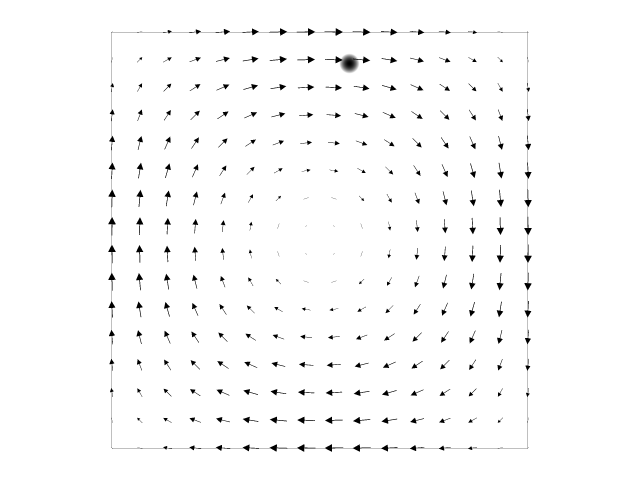

In [35]:
fig2.show()

Advection and Stokes system
-----

**Rising low density bubble**

Many geodynamical problems can be modelled by combining a Stokes system with an advection system. The advection systems moves the material forward in time in response to a velocity field, which is calculated by solving the Stokes system. 

Once the material particles have been moved the density and viscosity fields are changed, since this information is attached to the swarm particles tracking the material movement. 

Since the density and viscosity are different a new solve of the Stokes system is done and the process begins again. By stepping this process forward in time complex systems are solved.



Setup a bubble of low density fluid using particles and an advection system, which also needs a Stokes system each timestep to solve for the velocity field. *More details are given below; just before the main time loop*.


Setup new mesh and field variables

In [36]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight))
velocityField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

Make a swarm over the entire region.

In [37]:
# Initialise a swarm.
swarm = uw.swarm.Swarm( mesh=mesh )
# Add a data variable which will store an index to determine material.
materialVariable = swarm.add_variable( dataType="int", count=1 )
# Create a layout object that will populate the swarm across the whole domain.
swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
# Populate.
swarm.populate_using_layout( layout=swarmLayout )

Add a circle shape at the bottom with a different material index. Obtain the index for the first swarm particle that is inside the circle, this will correspond with the bottom left most particle. This makes for a quick way to track the movement of bubble as it rises. 

In [38]:
circleRadius = 0.05
circleCentre = (0.5, 2.0*circleRadius)
topBubbleID = 0
for pID in range(len(swarm.particleCoordinates.data)):
    x = swarm.particleCoordinates.data[pID][0]
    z = swarm.particleCoordinates.data[pID][1]
    xx = x - circleCentre[0]
    zz = z - circleCentre[1]
    condition = (xx*xx + zz*zz < circleRadius**2)
    if(condition == True):  # inside the circle
        materialVariable.data[pID] = 1
        if(topBubbleID==0):
            topBubbleID = pID # will be the bottom, left most particle that is inside the circle (useful for tracking)
    else:
        materialVariable.data[pID] = 0
print('Tracer particle id = {0:6d}; Initial x = {1:.3f}, y = {2:.3f}'
      .format(topBubbleID,swarm.particleCoordinates.data[topBubbleID][0]
      ,swarm.particleCoordinates.data[topBubbleID][1]))

Tracer particle id =    102; Initial x = 0.508, y = 0.055


Plot initial conditions


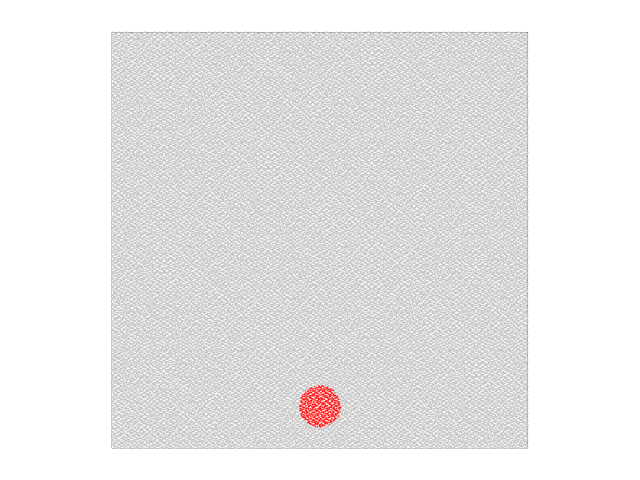

In [39]:
fig3 = glucifer.Figure()
fig3.append( glucifer.objects.Points( swarm=swarm, fn_colour=materialVariable, colours='grey red', 
                                colourBar = False, pointSize=2.0 ) )
fig3.show()

Set up the density, viscosity and buoyancy functions needed by the Stokes system. The density information in this example is carried by the swarm particles and is constructed using the branching function introduced in the user guide **05_Functions**.

Viscosity information is also associated with a material and therefore carried by swarm particles. In this example the viscosity is held constant ($\nu = 1$) across all materials.

The buoyancy function depends on the local fluid density and the vertical direction (opposite direction to gravity). All of these functions are defined here before the main simulation time loop and will be used any time they are needed by the system solvers or plotting etc.

In [40]:
# Here we set a density of '0.' for the lightMaterial (bubble), and '1.' for the heavymaterial.
lightIndex = 1
denseIndex = 0
densityMap = { lightIndex:0., denseIndex:1. }
densityFn  = fn.branching.map( fn_key = materialVariable, mapping = densityMap )

# Here we set a viscosity value of '1.' for both materials.
viscosityFn  = fn.misc.constant(1.0)

# Define our vertical unit vector using a python tuple (this will be automatically converted to a function).
z_hat = ( 0.0, 1.0 )
# Now create a buoyancy force vector using the density (FEvariable) and the vertical unit vector. 
buoyancyFn = -densityFn*z_hat

**Set velocity boundary conditions**

As mentioned previously, setting the boundary conditions for the velocity field in a Stokes system is more complex than for the temperature field. This is because while the temperature field has a single degree of freedom (T) at each mesh vertex, the velocity field has as many degrees of freedom as there are spatial dimensions; i.e. ${\bf v} = (v_x, v_y)$ for 2D.

In the example below Dirichlet conditions are set on the velocity field such that $v_x$ is constant on ``allWalls`` and $v_y$ is constant only on ``jWalls``. In plain English the horizontal component of the velocity field is fixed to the initial conditions ($v_x = 0$) on all boundaries, while the vertical component is only fixed on the top and bottom boundaries ($v_y = 0$).

If we wanted $v_y = 0$ on all boundaries then the second term in the ``stokesBC`` second field should be replaced with ``allWalls``.

In [41]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
allWalls = iWalls + jWalls

# Now, using these sets, decide which degrees of freedom (on each node) should be considered Dirichlet.
stokesBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                             indexSetsPerDof = (allWalls, jWalls) )

**Setup a non-linear Stokes system**

Setup a Stokes system which also needs information carried by the swarm. This time the density function depends on the material index of the swarm particles. The motion of the particles depends on the velocity field. This makes the system **non-linear**, as reflected when we solve the system in the time loop below.

In [42]:
stokesPIC = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               swarm         = swarm, 
                               conditions    = [stokesBC,],
                               viscosityFn   = viscosityFn, 
                               bodyForceFn   = buoyancyFn )
solver = uw.systems.Solver( stokesPIC )

Setup the advection system to be dependent on the velocity field, as before.

In [43]:
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )

Main simulation time loop.

In [44]:
time = 0.
time_end = 300.
step = 0
steps_end = 20
outputEvery = 5
while time < time_end:
    # Solve for the velocity field given the current temperature field.
    solver.solve( nonLinearIterate=True )
    # Retrieve the maximum possible timestep for the AD system.
    dt = advector.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    advector.integrate(dt)
    if step%outputEvery == 0:
        print('step = {0:3d}; t = {1:7.2f}; x = {2:.3f}, y = {3:.3f}'
              .format(step,time,swarm.particleCoordinates.data[topBubbleID][0]
              ,swarm.particleCoordinates.data[topBubbleID][1]))
    step += 1
    time += dt


step =   0; t =    0.00; x = 0.508, y = 0.055
step =   5; t =   47.09; x = 0.505, y = 0.077
step =  10; t =   96.16; x = 0.503, y = 0.102
step =  15; t =  138.87; x = 0.503, y = 0.128
step =  20; t =  177.45; x = 0.502, y = 0.155
step =  25; t =  213.32; x = 0.502, y = 0.183
step =  30; t =  247.57; x = 0.501, y = 0.209
step =  35; t =  280.42; x = 0.501, y = 0.236


Plot resulting bubble position and velocity field for the entire fluid.


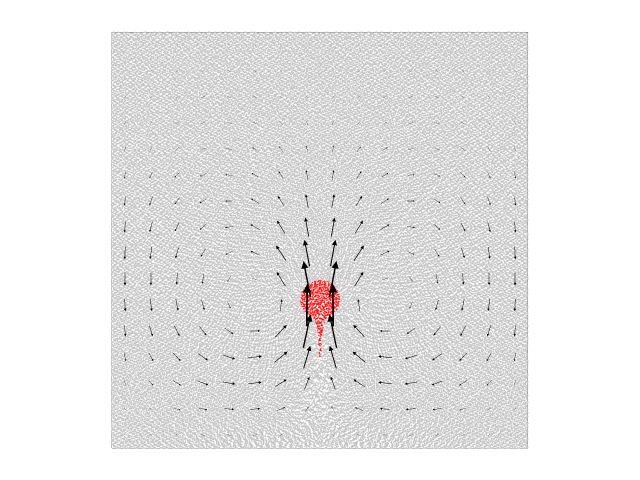

In [45]:
fig4 = glucifer.Figure()
fig4.append( glucifer.objects.VectorArrows( mesh, velocityField/(0.001), arrowHead=0.2, scaling=0.1 ) )
fig4.append( glucifer.objects.Points( swarm=swarm, fn_colour=materialVariable, colours='grey red', 
                                colourBar = False, pointSize=2.0 ) )
fig4.show()

More information
-----

This notebook has covered advection by the velocity field only, i.e. ``uw.systems.SwarmAdvector``. The other advector system type combines advection with diffusion (heat equation) using the command ``uw.systems.AdvectionDiffusion`` which requires the velocity and temperature fields to advect the particles. A simple example of such as system is given in the example **1_02_Convection_Example**.

For more information on the interaction between advection and Stokes systems the reader is directed to the examples directory, in particular **1_05_StokesSinker** and **1_06_Rayleigh_Taylor**.